# **Energy Consumption Forecasting with LSTM**

## **Oslo Data**

### LSTM Model

In [73]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset


# Load the data
data = pd.read_csv('consumption_temp.csv')

# Filter for 'Oslo'
oslo_data = data[data['location'] == 'oslo']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(oslo_data[['consumption', 'temperature']])

device = torch.device('cpu')

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.has_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')

def create_sequences(data, seq_length, pred_length):
    sequences = []
    future_temps = []
    targets = []

    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i+seq_length])
        future_temps.append(data[i+seq_length:i+seq_length+pred_length, 1])  # Future temperature
        targets.append(data[i+seq_length:i+seq_length+pred_length, 0])  # Future consumption

    sequences = np.array(sequences)
    future_temps = np.array(future_temps)
    targets = np.array(targets)

    # Convert sequences and targets into torch tensors
    sequences_tensor = torch.tensor(sequences, dtype=torch.float32)
    future_temps_tensor = torch.tensor(future_temps, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)

    return sequences_tensor, future_temps_tensor, targets_tensor


# This function will create the DataLoader objects that will handle the batching of data
def create_lstm_data_loaders(X_train_seq, future_temps_train, y_train_seq, X_test_seq, future_temps_test, y_test_seq, batch_size):
    # Create TensorDataset objects including future temperatures for both training and testing data
    train_dataset = TensorDataset(X_train_seq, future_temps_train, y_train_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_seq, future_temps_test, y_test_seq)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.pred_length = pred_length
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim + temp_input_dim, output_dim * pred_length)  # Output size accounts for temperature
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, future_temps):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=x.device).requires_grad_()
        # Forward pass through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out[:, -1, :])  # Use the output of the last time step

        # Reshape the future_temp tensor to be concatenated with LSTM output
        future_temps = future_temps.reshape(x.size(0), -1)

        # Concatenate the last output of LSTM with the future temperature
        combined = torch.cat((out, future_temps), dim=1)

        # Forward pass through the fully connected layer with the combined data
        out = self.fc(combined)
        return out


class LSTMTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.train_losses = []
        self.val_losses = []

    def train(self):
        for epoch in tqdm(range(self.num_epochs)):  # Wrap around tqdm for progress bar
            # Training
            self.model.train()
            running_loss = 0.0
            for (X_batch, future_temp_batch, y_batch) in self.train_loader:
                X_batch, future_temp_batch, y_batch = X_batch.to(device), future_temp_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(X_batch, future_temp_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * X_batch.size(0)
            self.train_losses.append(running_loss / len(self.train_loader.dataset))

            # Evaluation
            self.model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for X_batch, future_temp_batch, y_batch in self.test_loader:  # Include future_temp_batch here
                    X_batch, future_temp_batch, y_batch = X_batch.to(device), future_temp_batch.to(device), y_batch.to(device)
                    val_outputs = self.model(X_batch, future_temp_batch)  # Include future_temp_batch in the model call
                    val_loss = self.criterion(val_outputs, y_batch)
                    running_val_loss += val_loss.item() * X_batch.size(0)
            self.val_losses.append(running_val_loss / len(self.test_loader.dataset))

            # Scheduler step
            self.scheduler.step()

def initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim, device):
    model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    return model, criterion, optimizer, scheduler

def create_lstm_data_loaders(X_train_seq, future_temps_train, y_train_seq, X_test_seq, future_temps_test, y_test_seq, batch_size):
    # Include future temperatures in the datasets
    train_dataset = TensorDataset(X_train_seq, future_temps_train, y_train_seq)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_seq, future_temps_test, y_test_seq)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs):
    trainer = LSTMTrainer(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)
    trainer.train()
    return trainer


/var/folders/k0/gx88kp513zqbj9_8ls33bwbh0000gn/T/ipykernel_70925/1399543165.py:26: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  elif torch.has_mps:


## Training

In [74]:
seq_length = 120  # 5 days * 24 hours
pred_length = 24  # 1 day * 24 hours
X, future_temps, y = create_sequences(scaled_data, seq_length, pred_length)

# Split into training and test sets
train_size = int(0.8 * len(X))
X_train_seq = X[:train_size]
future_temps_train = future_temps[:train_size]
y_train_seq = y[:train_size]

X_test_seq = X[train_size:]
future_temps_test = future_temps[train_size:]
y_test_seq = y[train_size:]

# Initialize the model, criterion, optimizer, and scheduler
input_dim = 2
hidden_dim = 100
temp_input_dim = pred_length
num_layers = 2
output_dim = 1
model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim, device)

# Create DataLoader
batch_size = 64  # You can adjust this based on memory availability
train_loader, test_loader = create_lstm_data_loaders(X_train_seq, future_temps_train, y_train_seq, X_test_seq, future_temps_test, y_test_seq, batch_size)

# Train the model
num_epochs = 50
trainer = train_lstm_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs)

# Print the training and validation losses
print("Traineing avg. loss: ", np.mean(trainer.train_losses))
print("Validation avg. loss: ", np.mean(trainer.val_losses))

100%|██████████| 50/50 [01:51<00:00,  2.23s/it]

Traineing avg. loss:  0.010645074599640892
Validation avg. loss:  0.03371273869381231


### Forecasting

Mean Absolute Error (MAE): 0.13768832385540009
Mean Squared Error (MSE): 0.03499605879187584
Root Mean Squared Error (RMSE): 0.18707233667373657
R-squared: 0.7098595505562221


/var/folders/k0/gx88kp513zqbj9_8ls33bwbh0000gn/T/ipykernel_70925/3360224719.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oslo_data['time'] = pd.to_datetime(oslo_data['time'])


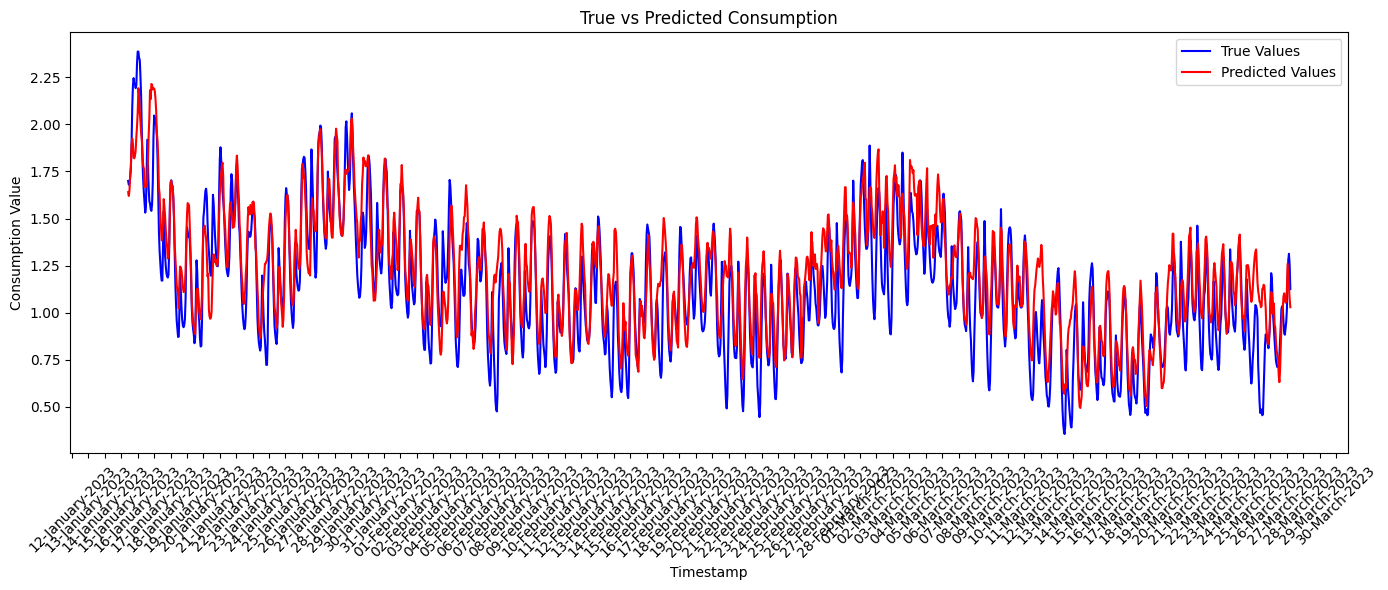

In [75]:
import matplotlib.dates as mdates
from datetime import datetime, timedelta

X_test_seq = X_test_seq.to(device)
future_temps_test = future_temps_test.to(device)

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq, future_temps_test)


# Convert predictions and actual values to numpy arrays for calculation
y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test_seq.cpu().numpy()

# Compute Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

import matplotlib.pyplot as plt

# Get true values for the next 24 hours from each sequence
true_values = y_test_np[:, -1]  # Get the last value from each sequence

# Get the predicted values for 24 hours ahead
predicted_values = y_pred_np[:, -1]

# Convert the 'timestamp' column to datetime format
oslo_data['time'] = pd.to_datetime(oslo_data['time'])

# Get the starting timestamp of the test set
initial_timestamp = oslo_data['time'].iloc[train_size + seq_length]  # The start of the test set, adjusted for the sequence length

# Generate a range of timestamps for the test set, taking every 24th hour since we're predicting for 24 hours ahead
timestamps = [initial_timestamp + pd.Timedelta(hours=i*24) for i in range(len(true_values))]

# Extracting the start date from the test dataset
start_date = oslo_data.iloc[train_size]['time'].to_pydatetime()

# Generating timestamps for each hour in the test set
hours = len(y_test_seq)
timestamps = [start_date + timedelta(hours=i) for i in range(hours)]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(timestamps, true_values, label='True Values', color='blue')
plt.plot(timestamps, predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('True vs Predicted Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption Value')

# Customizing the x-axis to show a label only at the start of every new day
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%B-%Y'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))  # place a major tick every 24 hours (i.e., every day)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


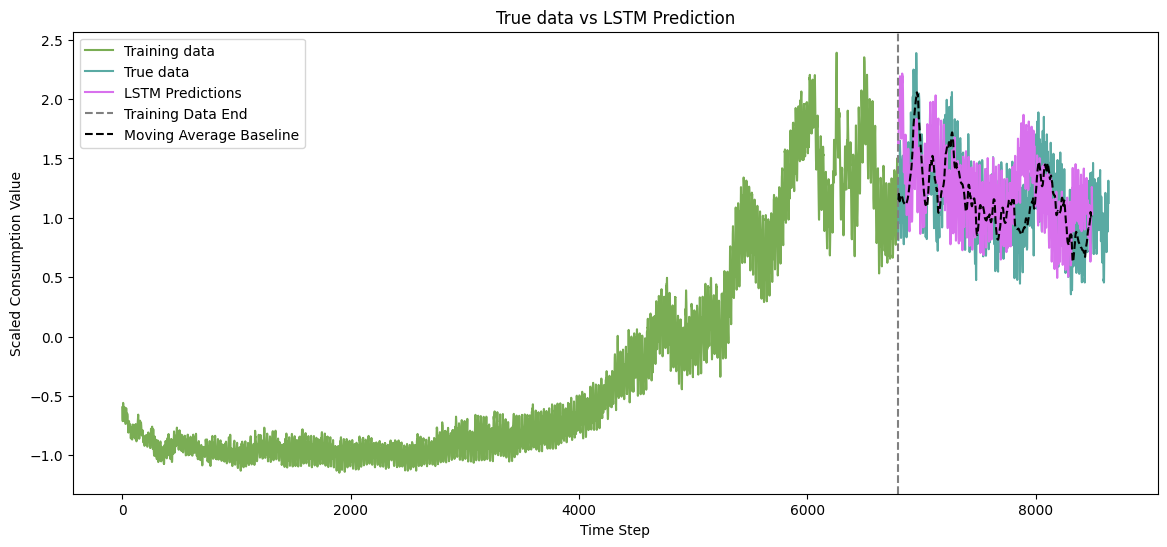

Moving Average Baseline Metrics:
Mean Absolute Error (MAE): 0.3055552602875524
Mean Squared Error (MSE): 0.1466502697570664
Root Mean Squared Error (RMSE): 0.3829494349872662
R-squared: -0.2630052331893633

LSTM Model Metrics:
Mean Absolute Error (MAE): 0.1411120891571045
Mean Squared Error (MSE): 0.03507662191987038
Root Mean Squared Error (RMSE): 0.18728753924369812
R-squared: 0.6979074487170001


In [76]:
# Create a rolling mean baseline using rolling() and mean()
rolling_mean_values = pd.Series(scaled_data[:, 0]).rolling(window=24).mean()
# Filter to just use test data
rolling_mean_values = rolling_mean_values.iloc[train_size:train_size+len(predicted_values)]


# Create a plot with scaled data and predictions
plt.figure(figsize=(14, 6))
plt.plot(scaled_data[:train_size, 0], label='Training data', color='#7AAD54')  # plot the first column of scaled_data before the vertical line
plt.plot(range(train_size, len(scaled_data)), scaled_data[train_size:, 0], label='True data', color='#5AAAA3')  # plot the first column of scaled_data after the vertical line
plt.plot(range(train_size, train_size+len(predicted_values)), predicted_values, label='LSTM Predictions', color='#D871ED')
plt.axvline(x=train_size, linestyle='--', color='gray', label='Training Data End')  # add a vertical line at the end of the training data
plt.plot(range(train_size, train_size+len(predicted_values)), rolling_mean_values, linestyle='--', color='black', label='Moving Average Baseline')  # add a horizontal line for the moving average baseline
plt.legend()
plt.title('True data vs LSTM Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled Consumption Value')
plt.show()

# Print error metrics for the moving average baseline and the LSTM model compared to the true values
mae_baseline = mean_absolute_error(true_values, rolling_mean_values)
mse_baseline = mean_squared_error(true_values, rolling_mean_values)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(true_values, rolling_mean_values)

mae_lstm = mean_absolute_error(true_values, predicted_values)
mse_lstm = mean_squared_error(true_values, predicted_values)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(true_values, predicted_values)

print(f"Moving Average Baseline Metrics:")
print(f"Mean Absolute Error (MAE): {mae_baseline}")
print(f"Mean Squared Error (MSE): {mse_baseline}")
print(f"Root Mean Squared Error (RMSE): {rmse_baseline}")
print(f"R-squared: {r2_baseline}")
print()
print(f"LSTM Model Metrics:")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm}")
print(f"R-squared: {r2_lstm}")




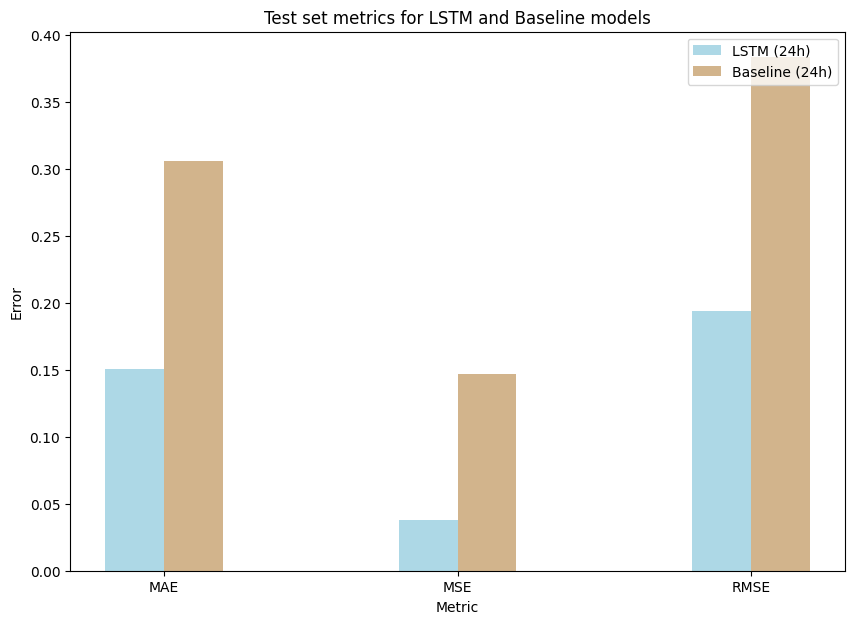

In [55]:
#MAE, MSE, RMSE, R2
lstm_values = [mae_lstm, mse_lstm, rmse_lstm]
baseline_values = [mae_baseline, mse_baseline, rmse_baseline]

labels = ['MAE', 'MSE', 'RMSE']
bar_width = 0.2

r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars
plt.bar(r1, lstm_values, width=bar_width, label='LSTM (24h)', color='lightblue')
plt.bar(r2, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

# Add some details
plt.title('Test set metrics for LSTM and Baseline models')
plt.xlabel('Metric')
plt.ylabel('Error')
plt.xticks([r + bar_width*0.5 for r in range(len(labels))], labels)
plt.legend(loc='upper right')


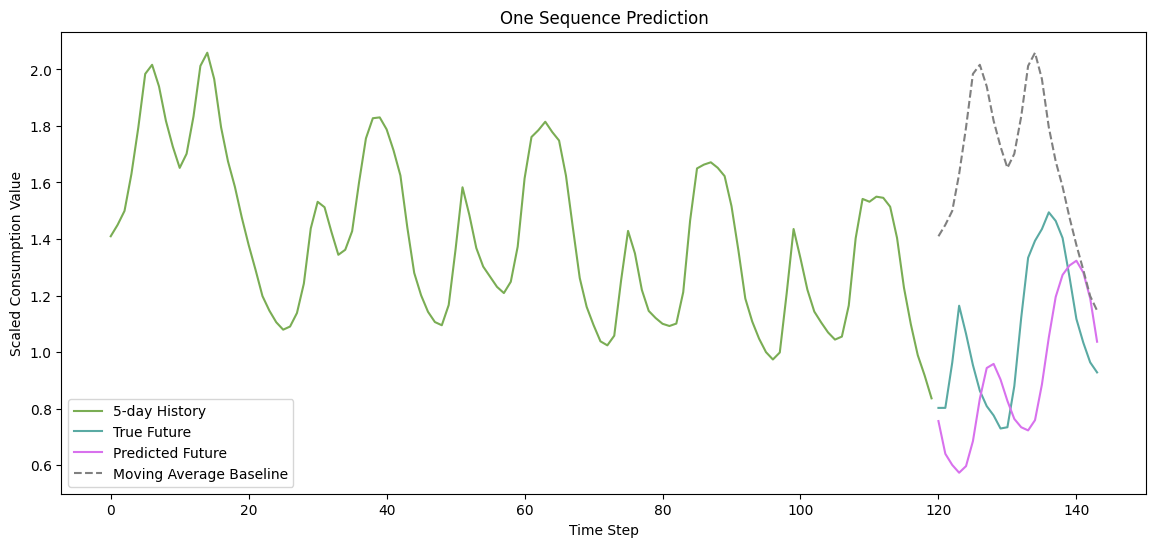

In [67]:
sequence_nr = 19*24  # 4 days * 24 hours

# Create a rolling mean baseline using rolling() and mean() from the test data filtered to just use the selected sequence
rolling_mean_values = pd.Series(scaled_data[train_size+sequence_nr:train_size+sequence_nr+pred_length, 0]).rolling(window=1).mean()

# Convert X_test_seq[sequence_nr] to numpy array if it's a tensor on a non-CPU device
X_test_seq_cpu = X_test_seq[sequence_nr].cpu().numpy()

# Convert y_test_seq[sequence_nr] to numpy array if it's a tensor on a non-CPU device
y_test_seq_cpu = y_test_seq[sequence_nr].cpu().numpy()

# Convert y_pred[sequence_nr] to numpy array if it's a tensor on a non-CPU device
y_pred_cpu = y_pred[sequence_nr].cpu().numpy()

# Plot a graph showing the predicted value of one sequence and the actual values for the next 24 hours with the 5-day history
plt.figure(figsize=(14, 6))
plt.plot(range(seq_length), X_test_seq_cpu[:, 0], label='5-day History', color='#7AAD54')
plt.plot(range(seq_length, seq_length+pred_length), y_test_seq_cpu, label='True Future', color='#5AAAA3')
plt.plot(range(seq_length, seq_length+pred_length), y_pred_cpu, label='Predicted Future', color='#D871ED')
plt.plot(range(seq_length, seq_length+pred_length), rolling_mean_values, linestyle='--', label='Moving Average Baseline', color='gray')
plt.legend()
plt.title('One Sequence Prediction')
plt.xlabel('Time Step')
plt.ylabel('Scaled Consumption Value')
plt.show()



## **Cross Validation**

### Time Series Split

In [60]:
# Time series split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tscv = TimeSeriesSplit(n_splits=5)
mae_TSS = []
mse_TSS = []
rmse_TSS = []
r2_TSS = []

X, future_temps, y = create_sequences(scaled_data, seq_length, pred_length)

training_data_list = []
y_pred_np_list = []
y_test_np_list = []

for train_index, test_index in tscv.split(X):
    cv_train, cv_test = X[train_index], X[test_index]
    cv_train_temps, cv_test_temps = future_temps[train_index], future_temps[test_index]
    cv_train_target, cv_test_target = y[train_index], y[test_index]

    cv_train_loader, cv_test_loader = create_lstm_data_loaders(cv_train, future_temps[train_index], cv_train_target, cv_test, future_temps[test_index], cv_test_target, batch_size)

    # Initialize the model, criterion, optimizer, and scheduler
    input_dim = 2
    temp_input_dim = pred_length
    hidden_dim = 100
    num_layers = 2
    output_dim = 1
    model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim, device)

    # Train the model
    num_epochs = 50
    trainer = train_lstm_model(model, criterion, optimizer, scheduler, cv_train_loader, cv_test_loader, num_epochs)
    
    # Make predictions on the test set
    cv_test = cv_test.to(device)
    cv_test_temps = cv_test_temps.to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(cv_test, cv_test_temps)

    # Convert predictions and actual values to numpy arrays for calculation
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = cv_test_target.cpu().numpy()

    # Append to lists
    training_data_list.append(cv_train)
    y_pred_np_list.append(y_pred_np)
    y_test_np_list.append(y_test_np)

    # Compute Evaluation Metrics
    mae_TSS.append(mean_absolute_error(y_test_np, y_pred_np))
    mse_TSS.append(mean_squared_error(y_test_np, y_pred_np))
    rmse_TSS.append(np.sqrt(mse_TSS[-1]))
    r2_TSS.append(r2_score(y_test_np, y_pred_np))

print("MAE", mae_TSS)
print("MSE", mse_TSS)
print("RMSE", rmse_TSS)
print("R2", r2_TSS)




100%|██████████| 50/50 [01:53<00:00,  2.27s/it]


MAE [0.05201794, 0.11358421, 0.40331784, 0.24718647, 0.12415523]
MSE [0.004415231, 0.021669505, 0.28565052, 0.09336677, 0.027360061]
RMSE [0.066447206, 0.14720565, 0.5344628, 0.30555975, 0.16540878]
R2 [0.3949508824763493, 0.3758207872391561, -0.31302505879107284, 0.34914984225990825, 0.7197994902688788]


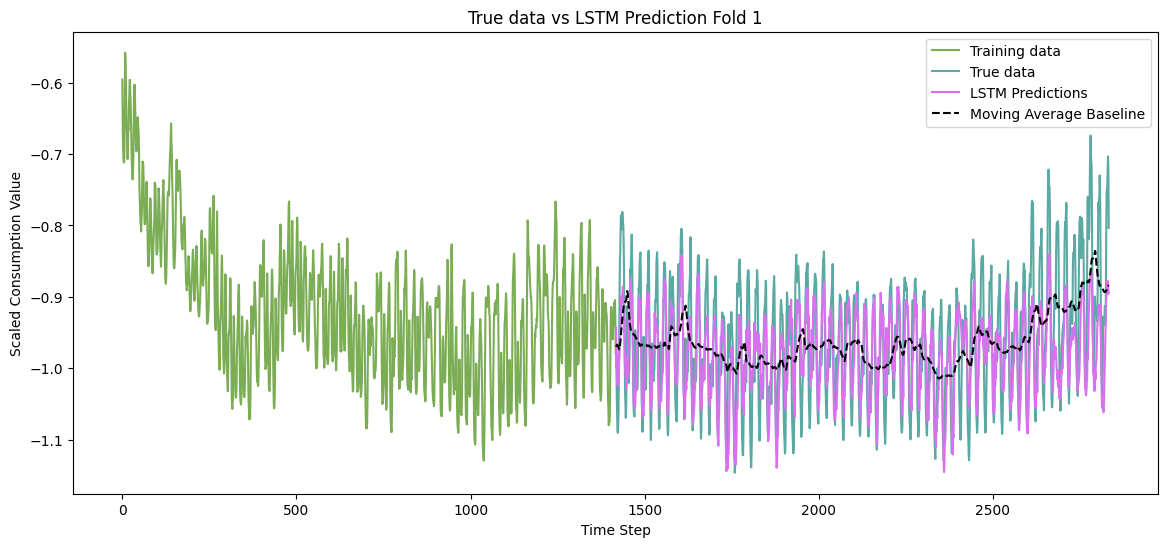

LSTM-TSS Error Metrics for Fold 1
MAE 0.05201794
MSE 0.004415231
RMSE 0.066447206
R2 0.3949508824763493

Baseline Error Metrics for Fold 1
MAE 0.06870934198805168
MSE 0.006423280884715433
RMSE 0.0801453734454799
R2 0.1385177649019681


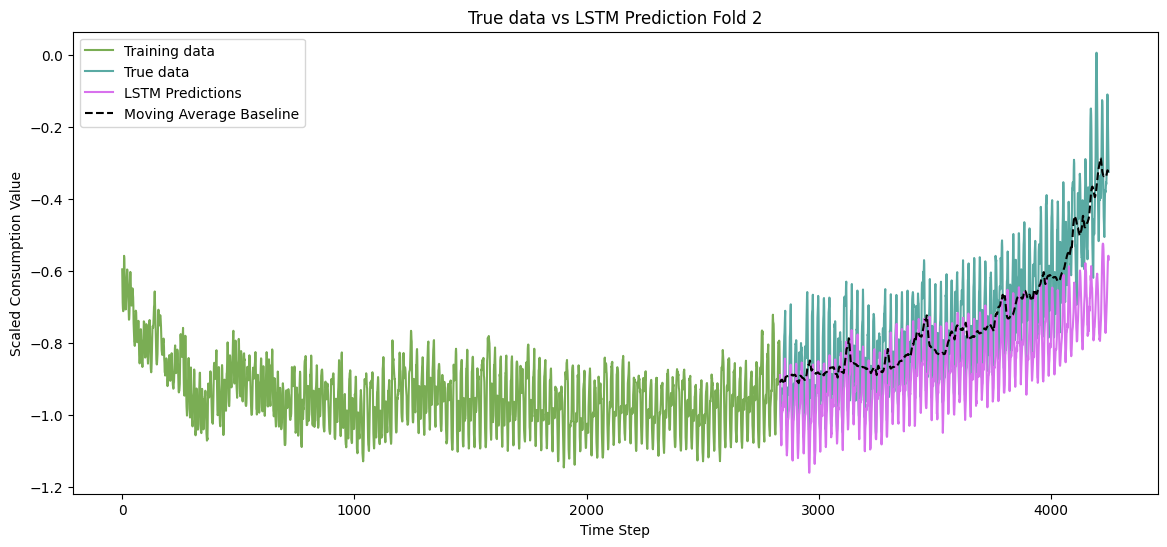

LSTM-TSS Error Metrics for Fold 2
MAE 0.11358421
MSE 0.021669505
RMSE 0.14720565
R2 0.3758207872391561

Baseline Error Metrics for Fold 2
MAE 0.0959182642268174
MSE 0.012398156074127293
RMSE 0.11134700747719847
R2 0.6607379778560749


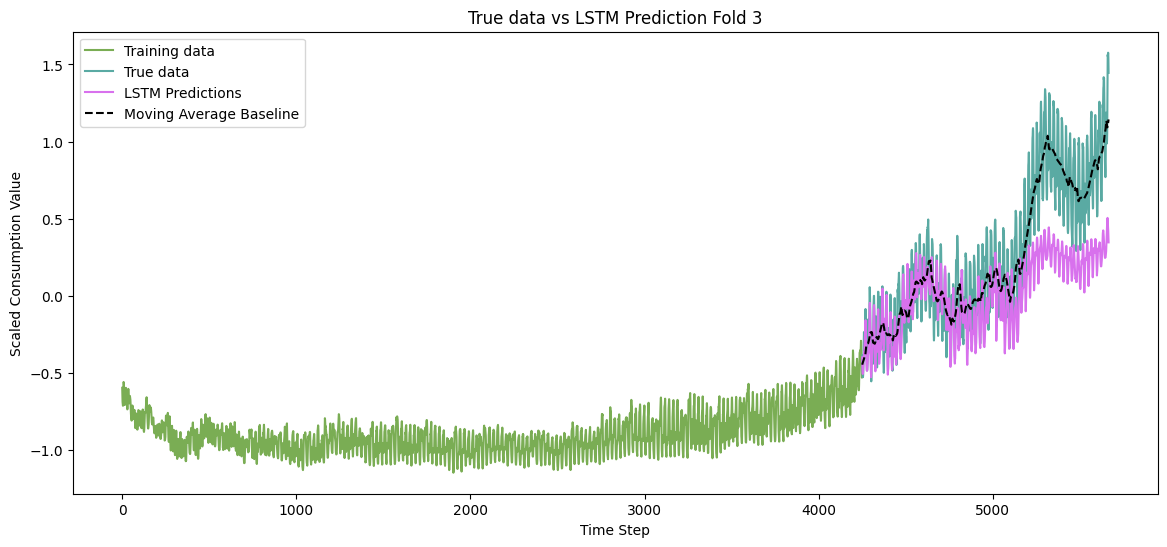

LSTM-TSS Error Metrics for Fold 3
MAE 0.40331784
MSE 0.28565052
RMSE 0.5344628
R2 -0.31302505879107284

Baseline Error Metrics for Fold 3
MAE 0.17722152872075467
MSE 0.042899428815484385
RMSE 0.2071217729150762
R2 0.8097653867805326


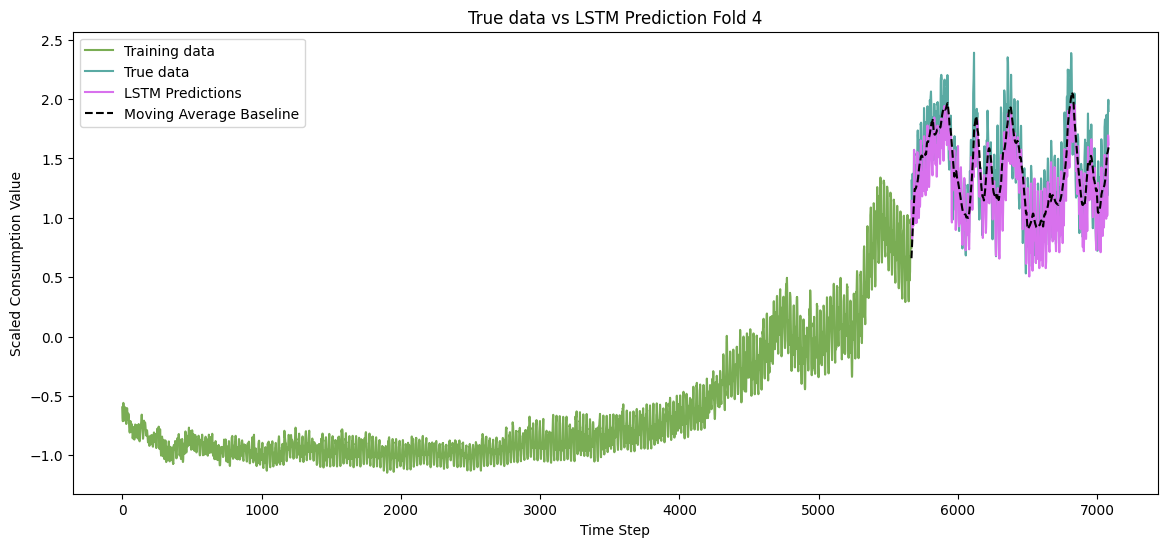

LSTM-TSS Error Metrics for Fold 4
MAE 0.24718647
MSE 0.09336677
RMSE 0.30555975
R2 0.34914984225990825

Baseline Error Metrics for Fold 4
MAE 0.21079728989151575
MSE 0.0634821729063696
RMSE 0.25195668855255576
R2 0.5593614316771931


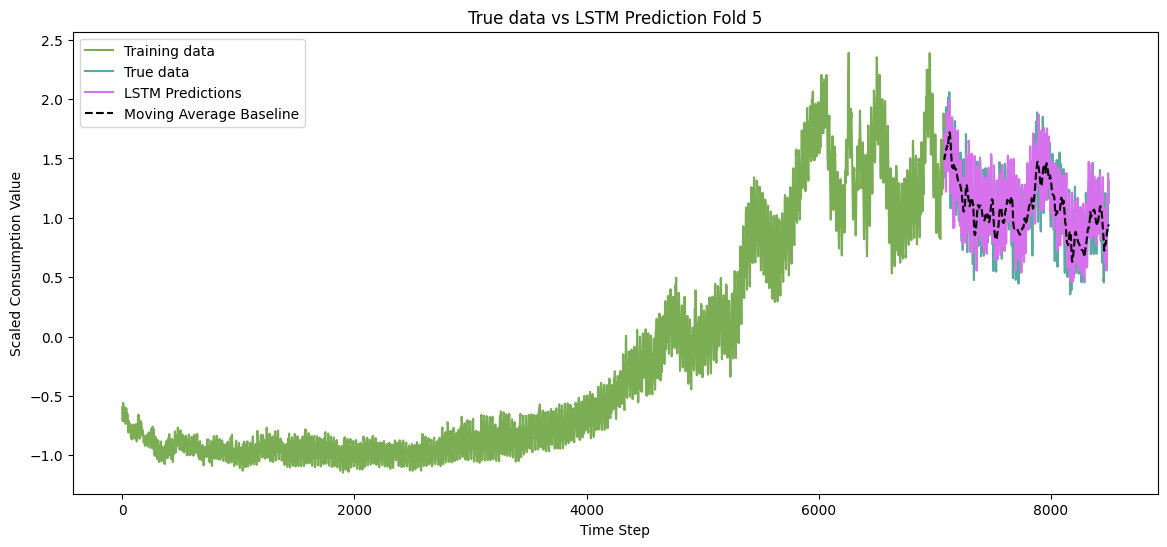

LSTM-TSS Error Metrics for Fold 5
MAE 0.12415523
MSE 0.027360061
RMSE 0.16540878
R2 0.7197994902688788

Baseline Error Metrics for Fold 5
MAE 0.1915903152484033
MSE 0.05255987299204151
RMSE 0.22925940109849696
R2 0.44303939585405405


LSTM-TSS Error Metrics Average
MAE 0.18805234
MSE 0.08649242
RMSE 0.24381682
R2 0.3053391886906439

Baseline Error Metrics Average
MAE 0.14884734801510854
MSE 0.035552582334547646
RMSE 0.17596604869776145
R2 0.5222843914139645


In [61]:
mae_baseline_TSS = []
mse_baseline_TSS = []
rmse_baseline_TSS = []
r2_baseline_TSS = []

# For each fold, plot the predictions vs actual values
for fold_nr in range(0, 5):

    # Plot predictions vs actual values an training values
    train_values = training_data_list[fold_nr][:, 0, 0].reshape(-1, 1)


    true_values = y_test_np_list[fold_nr][:, -1]
    pred_values = y_pred_np_list[fold_nr][:, -1]

    # Combine train and test values
    fold_values = np.concatenate((train_values.cpu().numpy()[:, -1], true_values))

    # Create a rolling mean baseline using rolling() and mean()
    rolling_mean_values_TSS = pd.Series(fold_values).rolling(window=24).mean()
    # Filter to just use pred values
    rolling_mean_values_TSS = rolling_mean_values_TSS.iloc[-len(true_values):]

    mae_baseline_TSS.append(mean_absolute_error(true_values, rolling_mean_values_TSS))
    mse_baseline_TSS.append(mean_squared_error(true_values, rolling_mean_values_TSS))
    rmse_baseline_TSS.append(np.sqrt(mse_baseline_TSS[-1]))
    r2_baseline_TSS.append(r2_score(true_values, rolling_mean_values_TSS))

    plt.figure(figsize=(14, 6))
    plt.plot(train_values.cpu(), label='Training data', color='#7AAD54')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), true_values, label='True data', color='#5AAAA3')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), pred_values, label='LSTM Predictions', color='#D871ED')
    plt.plot(range(len(train_values), len(train_values) + len(true_values)), rolling_mean_values_TSS, linestyle='--', color='black', label='Moving Average Baseline')  # add a horizontal line for the moving average baseline
    plt.legend()
    plt.title('True data vs LSTM Prediction Fold ' + str(fold_nr+1))
    plt.xlabel('Time Step')
    plt.ylabel('Scaled Consumption Value')
    plt.show()

    print("LSTM-TSS Error Metrics for Fold " + str(fold_nr+1))
    print("MAE", mae_TSS[fold_nr])
    print("MSE", mse_TSS[fold_nr])
    print("RMSE", rmse_TSS[fold_nr])
    print("R2", r2_TSS[fold_nr])

    print("\nBaseline Error Metrics for Fold " + str(fold_nr+1))
    print("MAE", mean_absolute_error(true_values, rolling_mean_values_TSS))
    print("MSE", mean_squared_error(true_values, rolling_mean_values_TSS))
    print("RMSE", np.sqrt(mean_squared_error(true_values, rolling_mean_values_TSS)))
    print("R2", r2_score(true_values, rolling_mean_values_TSS))

print("\n\nLSTM-TSS Error Metrics Average")
print("MAE", np.mean(mae_TSS))
print("MSE", np.mean(mse_TSS))
print("RMSE", np.mean(rmse_TSS))
print("R2", np.mean(r2_TSS))

print("\nBaseline Error Metrics Average")
print("MAE", np.mean(mae_baseline_TSS))
print("MSE", np.mean(mse_baseline_TSS))
print("RMSE", np.mean(rmse_baseline_TSS))
print("R2", np.mean(r2_baseline_TSS))

In [62]:
print("MAE", mae_TSS)

#Array of metrics
TSS_error_metrics = np.array([np.mean(mae_TSS), np.mean(mse_TSS), np.mean(rmse_TSS), np.mean(r2_TSS)])

# Array with all folds
TSS_error_metrics_folds = [mae_TSS, mse_TSS, rmse_TSS, r2_TSS]

print(f"Mean Absolute Error (MAE): {np.mean(mae_TSS)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_TSS)}")
print(f"Root Mean Squared Error (RMSE): {np.mean(rmse_TSS)}")
print(f"R-squared: {np.mean(r2_TSS)}")

MAE [0.05201794, 0.11358421, 0.40331784, 0.24718647, 0.12415523]
Mean Absolute Error (MAE): 0.18805234134197235
Mean Squared Error (MSE): 0.08649241924285889
Root Mean Squared Error (RMSE): 0.2438168227672577
R-squared: 0.3053391886906439


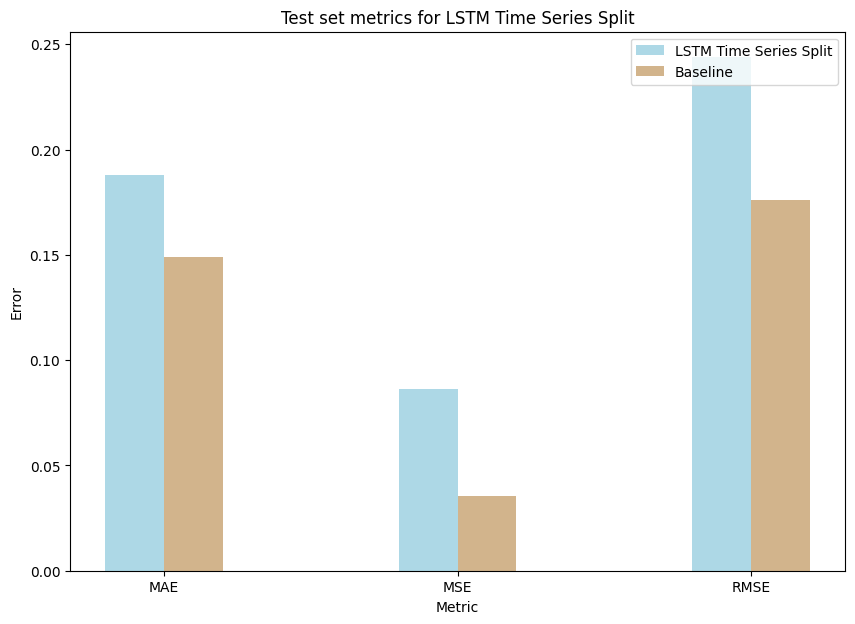

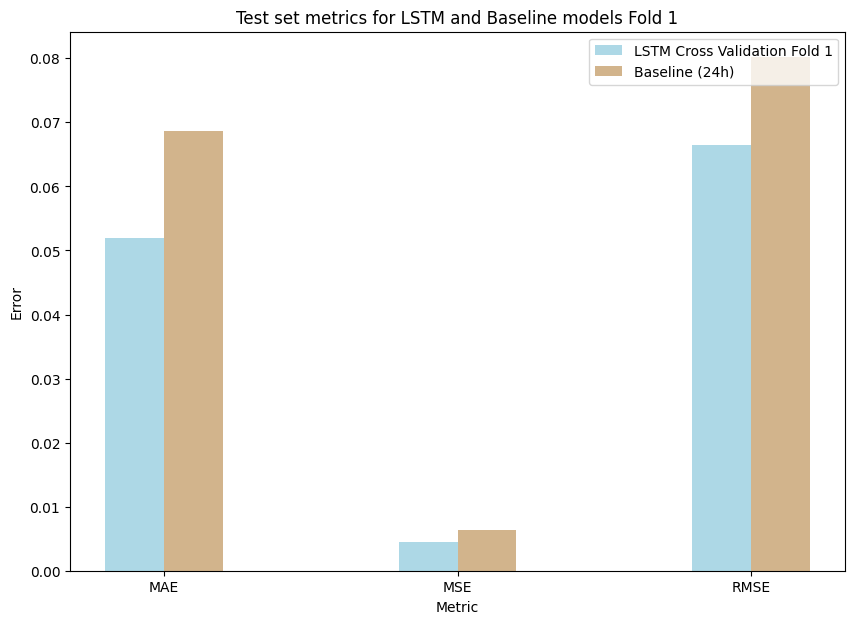

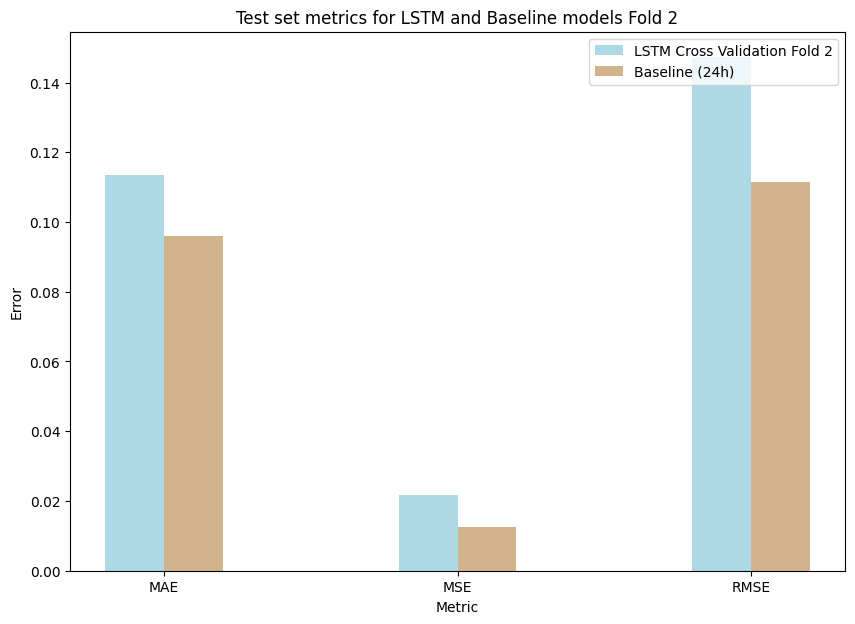

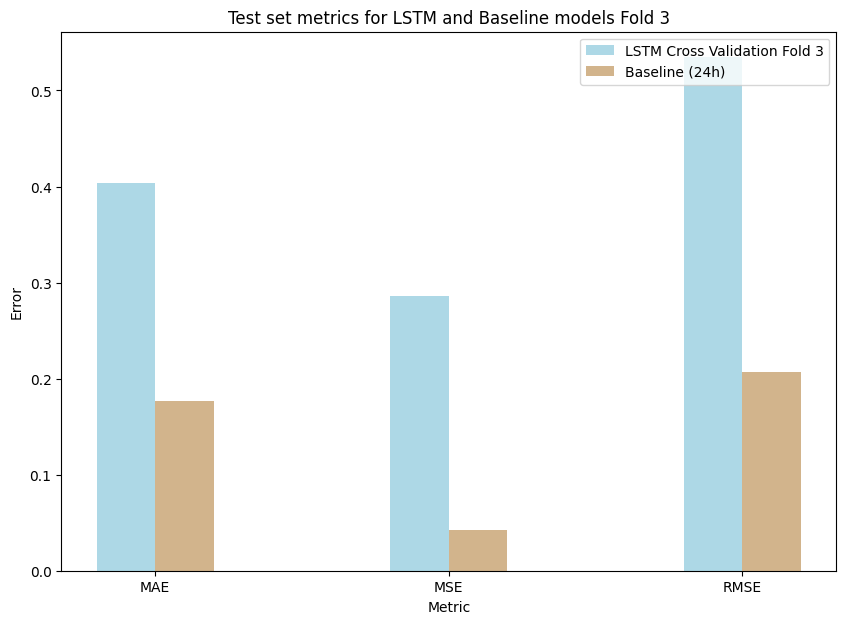

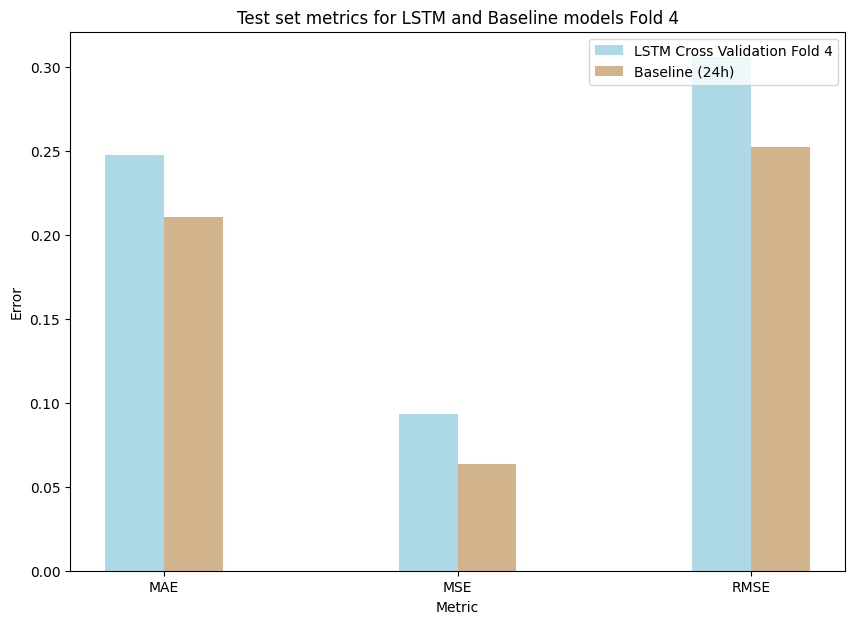

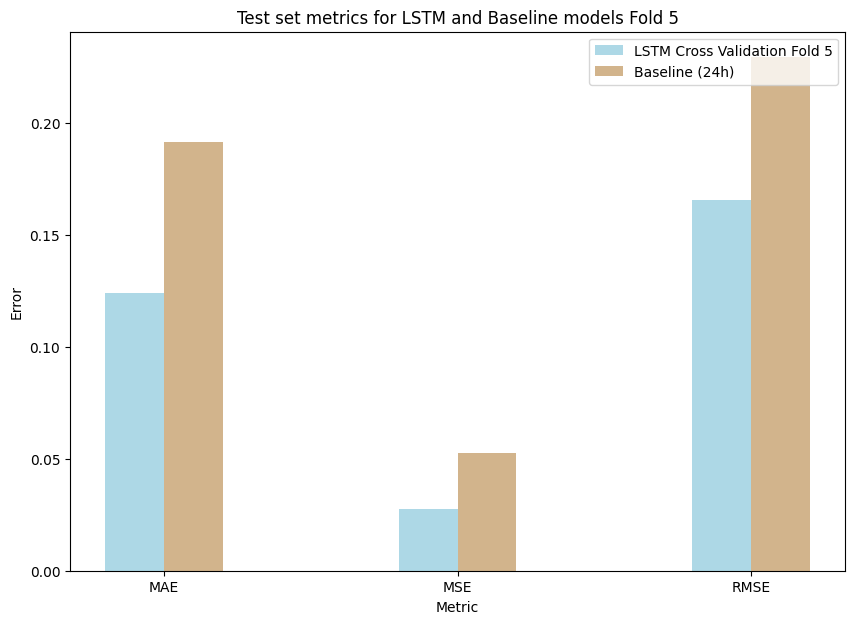

In [65]:
# Plot the average metrics for the Time Series Split
TSS_error_metrics = [np.mean(mae_TSS), np.mean(mse_TSS), np.mean(rmse_TSS)]
baseline_values_TSS = [np.mean(mae_baseline_TSS), np.mean(mse_baseline_TSS), np.mean(rmse_baseline_TSS)]

labels = ['MAE', 'MSE', 'RMSE']
bar_width = 0.2

r1 = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars
plt.bar(r1, TSS_error_metrics, width=bar_width, label='LSTM Time Series Split', color='lightblue')
plt.bar(r1 + bar_width, baseline_values_TSS, width=bar_width, label='Baseline', color='tan')

# Add some details
plt.title('Test set metrics for LSTM Time Series Split')
plt.xlabel('Metric')
plt.ylabel('Error')
plt.xticks([r + bar_width*0.5 for r in range(len(labels))], labels)
plt.legend(loc='upper right')

plt.show()

# Plot the metrics for each fold
for fold_nr in range(0, 5):
    # Select the metrics for the current fold
    fold_metrics = [mae_TSS[fold_nr], mse_TSS[fold_nr], rmse_TSS[fold_nr]]
    baseline_values = [mae_baseline_TSS[fold_nr], mse_baseline_TSS[fold_nr], rmse_baseline_TSS[fold_nr]]

    labels = ['MAE', 'MSE', 'RMSE']
    bar_width = 0.2

    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]

    fig, ax = plt.subplots(figsize=(10, 7))

    # Create bars
    plt.bar(r1, fold_metrics, width=bar_width, label='LSTM Cross Validation Fold ' + str(fold_nr+1), color='lightblue')
    plt.bar(r2, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

    # Add some details
    plt.title('Test set metrics for LSTM and Baseline models Fold ' + str(fold_nr+1))
    plt.xlabel('Metric')
    plt.ylabel('Error')
    plt.xticks([r + bar_width*0.5 for r in range(len(labels))], labels)
    plt.legend(loc='upper right')

    plt.show()

### Blocking Time Series Split

In [ ]:
# Blocking Time Series Split
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

tscv = BlockingTimeSeriesSplit(n_splits=5)
mae_BTSS = []
mse_BTSS = []
rmse_BTSS = []
r2_BTSS = []

X, y = create_sequences(scaled_data, seq_length, pred_length)

for train_index, test_index in tscv.split(X):
    cv_train, cv_test = X[train_index], X[test_index]
    cv_train_target, cv_test_target = y[train_index], y[test_index]

    # Create DataLoader
    batch_size = 64  # You can adjust this based on memory availability
    cv_train_dataset = TensorDataset(cv_train, cv_train_target)
    cv_train_loader = DataLoader(cv_train_dataset, batch_size=batch_size, shuffle=True)

    cv_test_dataset = TensorDataset(cv_test, cv_test_target)
    cv_test_loader = DataLoader(cv_test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, optimizer, and scheduler
    input_dim = 2
    hidden_dim = 100
    num_layers = 2
    output_dim = 1
    model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, device)

    # Train the model
    num_epochs = 50
    trainer = train_lstm_model(model, criterion, optimizer, scheduler, cv_train_loader, cv_test_loader, num_epochs)

    # Make predictions on the test set
    model.eval()
    with torch.no_grad():
        y_pred = model(cv_test)

    # Convert predictions and actual values to numpy arrays for calculation
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = cv_test_target.cpu().numpy()

    # Compute Evaluation Metrics
    mae_BTSS.append(mean_absolute_error(y_test_np, y_pred_np))
    mse_BTSS.append(mean_squared_error(y_test_np, y_pred_np))
    rmse_BTSS.append(np.sqrt(mse_BTSS[-1]))
    r2_BTSS.append(r2_score(y_test_np, y_pred_np))

print(f"Mean Absolute Error (MAE): {np.mean(mae_BTSS)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_BTSS)}")
print(f"Root Mean Squared Error (RMSE): {np.mean(rmse_BTSS)}")
print(f"R-squared: {np.mean(r2_BTSS)}")

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


Mean Absolute Error (MAE): 0.20041611790657043
Mean Squared Error (MSE): 0.07371924817562103
Root Mean Squared Error (RMSE): 0.2459350824356079
R-squared: -0.4693323318082344


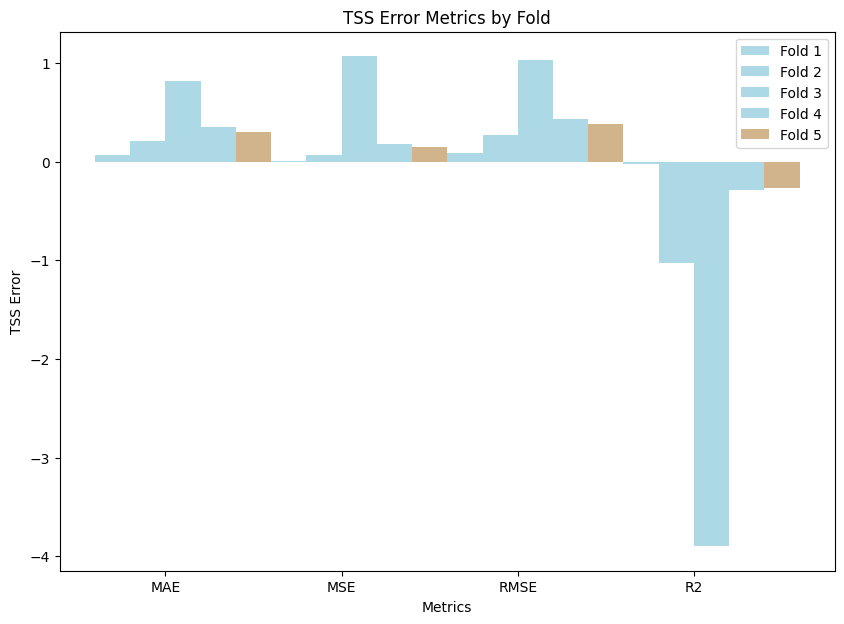

In [ ]:
# Plot the time series cross validation vs baseline error metrics
num_folds = len(TSS_error_metrics_folds)
fold_lists = []

for i in range(num_folds):
    fold = [TSS_error_metrics_folds[j][i] for j in range(len(TSS_error_metrics_folds))]
    fold_lists.append(fold)

baseline_values = [mae_baseline, mse_baseline, rmse_baseline, r2_baseline]

labels = ['MAE', 'MSE', 'RMSE', 'R2']
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 7))

# Create bars
for i, fold in enumerate(fold_lists):
    r = np.arange(len(fold)) + i * bar_width
    plt.bar(r, fold, width=bar_width, color='lightblue')

# Create baseline bars
r = [x + bar_width * num_folds for x in range(len(baseline_values))]
plt.bar(r, baseline_values, width=bar_width, label='Baseline (24h)', color='tan')

# Add xticks and labels
plt.title('Time Series Cross Validation vs Baseline')
plt.xticks([r + bar_width*1.5 for r in range(len(labels))], labels)
plt.xlabel('Metrics')
plt.ylabel('TSS Error')
plt.title('TSS Error Metrics by Fold')
plt.legend(['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5'])
plt.show()



In [70]:
# helsingfors data
# Filter for 'helsingfors'
helsingfors_data = data[data['location'] == 'helsingfors']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(helsingfors_data[['consumption', 'temperature']])

# Create sequences
X, future_temps, y = create_sequences(scaled_data, seq_length, pred_length)

# Split into training and test sets
train_size = int(0.8 * len(X))
X_train_seq = X[:train_size]
future_temps_train = future_temps[:train_size]
y_train_seq = y[:train_size]

X_test_seq = X[train_size:]
future_temps_test = future_temps[train_size:]
y_test_seq = y[train_size:]

# Create DataLoader
batch_size = 64 
train_loader, test_loader = create_lstm_data_loaders(X_train_seq, future_temps_train, y_train_seq, X_test_seq, future_temps_test, y_test_seq, batch_size)

# Initialize the model, criterion, optimizer, and scheduler
input_dim = 2
hidden_dim = 100
num_layers = 2
output_dim = 1
temp_input_dim = pred_length
model, criterion, optimizer, scheduler = initialize_lstm_model(input_dim, hidden_dim, num_layers, output_dim, pred_length, temp_input_dim, device)

# Train the model
num_epochs = 50
trainer = train_lstm_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs)

# Print the training and validation losses
print(trainer.train_losses)
print(trainer.val_losses)


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

[0.11378780761817008, 0.04265690727676193, 0.04126493312400274, 0.038629877624276984, 0.03896743983054569, 0.03772445684306451, 0.03567763887485224, 0.03422428244699105, 0.03556100551290566, 0.03525766490847236, 0.03579014070495733, 0.037495069257290604, 0.035944223018973896, 0.03618261705329255, 0.03754060400802978, 0.0331938865543794, 0.030785116498139548, 0.03080349604684808, 0.03154739286929393, 0.03663881519995781, 0.031747516590201634, 0.030239783031934156, 0.030413834852499145, 0.02867149969182478, 0.029882859553841675, 0.03154218445272102, 0.029430464465562117, 0.02783422722224301, 0.02845376440338287, 0.03046212104536393, 0.02866913431890133, 0.028122771394941456, 0.027733230549596595, 0.028029921810931554, 0.028068369868278892, 0.02837643880272804, 0.026141627803838913, 0.02560846297641757, 0.031739870115108273, 0.029495358764155304, 0.029830647849207297, 0.028061740312564653, 0.027493663668705256, 0.028255574726495827, 0.027599032977376165, 0.02649908089681405, 0.02701754318

## **Helsingfors Data**

Mean Absolute Error (MAE): 0.09764792770147324
Mean Squared Error (MSE): 0.04598178341984749
Root Mean Squared Error (RMSE): 0.21443364024162292
R-squared: -0.12175911777025038


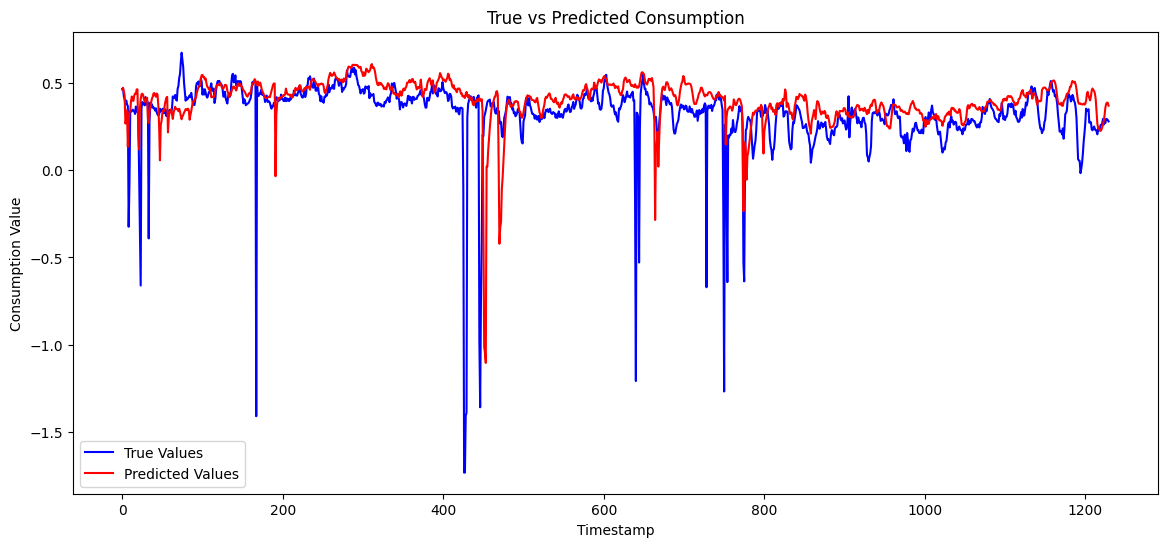

In [72]:
X_test_seq = X_test_seq.to(device)
future_temps_test = future_temps_test.to(device)

# Make predictions on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq, future_temps_test)

# Convert predictions and actual values to numpy arrays for calculation
y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test_seq.cpu().numpy()

# Compute Evaluation Metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# Get true values for the next 24 hours from each sequence
true_values = y_test_np[:, -1]  # Get the last value from each sequence

# Get the predicted values for 24 hours ahead
predicted_values = y_pred_np[:, -1]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')
plt.legend()
plt.title('True vs Predicted Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption Value')
plt.show()